# Solves Pong with Policy Gradients in Tensorflow

written October 2016 by Sam Greydanus

inspired by gist.github.com/karpathy/a4166c7fe253700972fcbc77e4ea32c5

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt

import numpy as np
import gym
import tensorflow as tf

In [2]:
n_obs = 80 * 80        # dimensionality of observations
h = 200                # number of hidden layer neurons
n_actions = 3          # number of available actions

learning_rate = 5e-4
gamma = .99            # discount factor for reward
decay = 0.992           # decay rate for RMSProp gradients
save_path='Pong-v0/pong.ckpt'

In [3]:
tf_model = {}
with tf.variable_scope('layer_one',reuse=False):
    xavier_l1 = tf.truncated_normal_initializer(mean=0, stddev=1./np.sqrt(n_obs), dtype=tf.float32)
    tf_model['W1'] = tf.get_variable("W1", [n_obs, h], initializer=xavier_l1)
with tf.variable_scope('layer_two',reuse=False):
    xavier_l2 = tf.truncated_normal_initializer(mean=0, stddev=1./np.sqrt(h), dtype=tf.float32)
    tf_model['W2'] = tf.get_variable("W2", [h,n_actions], initializer=xavier_l2)

In [4]:
def tf_discount_rewards(tf_r): #tf_r ~ [game_steps,1]
    discount_f = lambda a, v: a*gamma + v;
    tf_r_reverse = tf.scan(discount_f, tf.reverse(tf_r,[True, False]))
    tf_discounted_r = tf.reverse(tf_r_reverse,[True, False])
    return tf_discounted_r

def tf_policy_forward(x): #x ~ [1,D]
    h = tf.matmul(x, tf_model['W1'])
    h = tf.nn.relu(h)
    logp = tf.matmul(h, tf_model['W2'])
    p = tf.nn.softmax(logp)
    return p

def prepro(I):
    """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
    I = I[35:195] # crop
    I = I[::2,::2,0] # downsample by factor of 2
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    return I.astype(np.float).ravel()

def plt_dynamic(x, y, ax, colors=['b']):
    for color in colors:
        ax.plot(x, y, color)
    fig.canvas.draw()

In [5]:
#placeholders
tf_x = tf.placeholder(dtype=tf.float32, shape=[None, n_obs],name="tf_x")
tf_y = tf.placeholder(dtype=tf.float32, shape=[None, n_actions],name="tf_y")
tf_epr = tf.placeholder(dtype=tf.float32, shape=[None,1], name="tf_epr")

#gradient processing (PG magic)
tf_discounted_epr = tf_discount_rewards(tf_epr)
tf_mean, tf_variance= tf.nn.moments(tf_discounted_epr, [0], shift=None, name="reward_moments")
tf_discounted_epr -= tf_mean
tf_discounted_epr /= tf.sqrt(tf_variance + 1e-6)

# initialize tf graph
tf_aprob = tf_policy_forward(tf_x)
loss = tf.nn.l2_loss(tf_y-tf_aprob)
optimizer = tf.train.RMSPropOptimizer(learning_rate, decay=decay)
tf_grads = optimizer.compute_gradients(loss, var_list=tf.trainable_variables(), grad_loss=tf_discounted_epr)
train_op = optimizer.apply_gradients(tf_grads)

sess = tf.InteractiveSession()
tf.initialize_all_variables().run()

In [6]:
env = gym.make("Pong-v0")
observation = env.reset()
prev_x = None
xs,rs,ys = [],[],[]
running_reward = 2 # usually starts around -20.48 for Pong
reward_sum = 0
episode_number = 0

[2016-10-21 10:39:56,282] Making new env: Pong-v0


In [7]:
saver = tf.train.Saver(tf.all_variables())
load_was_success = True # yes, I'm being optimistic
try:
    save_dir = '/'.join(save_path.split('/')[:-1])
    ckpt = tf.train.get_checkpoint_state(save_dir)
    load_path = ckpt.model_checkpoint_path
    saver.restore(sess, load_path)
except:
    print "no saved model to load. starting new session"
    load_was_success = False
else:
    print "loaded model: {}".format(load_path)
    saver = tf.train.Saver(tf.all_variables())
    episode_number = int(load_path.split('-')[-1])

loaded model: Pong-v0/pong.ckpt-22500


<IPython.core.display.Javascript object>


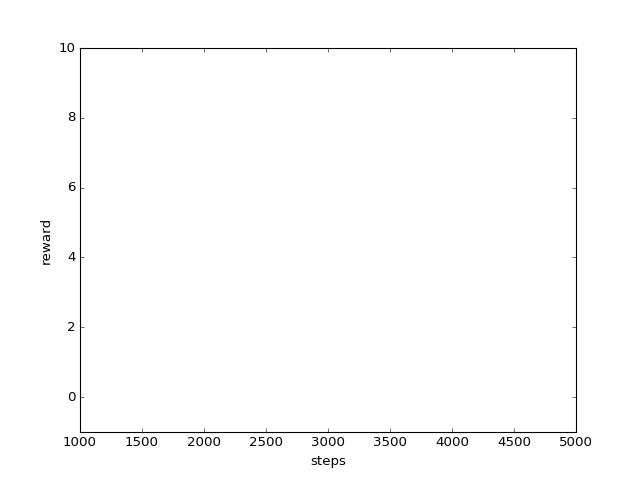

ep 22500: starting up...
ep: 22500, reward: 9.0, mean reward: 2.070000
SAVED MODEL #22500
	ep: 22501, reward: -11.0
	ep: 22502, reward: 12.0
	ep: 22503, reward: 10.0
	ep: 22504, reward: 11.0
	ep: 22505, reward: 5.0
	ep: 22506, reward: 4.0
	ep: 22507, reward: 15.0
	ep: 22508, reward: 16.0


KeyboardInterrupt: 

In [8]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('steps') ; ax.set_ylabel('reward')
ax.set_xlim(1000,5000) ; ax.set_ylim(-1,10)
pxs, pys = [], []

print 'ep {}: starting up...'.format(episode_number)
count = 0
while count < 100:
#     if True: env.render()
        
    # preprocess the observation, set input to network to be difference image
    cur_x = prepro(observation)
    x = cur_x - prev_x if prev_x is not None else np.zeros(n_obs)
    prev_x = cur_x

    # stochastically sample a policy from the network
    feed = {tf_x: np.reshape(x, (1,-1))}
    aprob = sess.run(tf_aprob,feed) ; aprob = aprob[0,:]
    action = np.random.choice(n_actions, p=aprob)
    label = np.zeros_like(aprob) ; label[action] = 1

    # step the environment and get new measurements
    observation, reward, done, info = env.step(action+1)
    reward_sum += reward
    
    # record game history
    xs.append(x) ; ys.append(label) ; rs.append(reward)
    
    if done:
        count+=1
        running_reward = running_reward * 0.99 + reward_sum * 0.01
        epx = np.vstack(xs)
        epr = np.vstack(rs)
        epy = np.vstack(ys)
        xs,rs,ys = [],[],[] # reset game history
        
        feed = {tf_x: epx, tf_epr: epr, tf_y: epy}
        _ = sess.run(train_op,feed) # parameter update

        # visualization
        pxs.append(episode_number)
        pys.append(running_reward)
        if episode_number % 10 == 0:
            print 'ep: {}, reward: {}, mean reward: {:3f}'.format(episode_number, reward_sum, running_reward)
            plt_dynamic(pxs, pys, ax)
        else:
            print '\tep: {}, reward: {}'.format(episode_number, reward_sum)
            
        if episode_number % 50 == 0:
            saver.save(sess, save_path, global_step=episode_number)
            print "SAVED MODEL #{}".format(episode_number)
        
        # lame stuff
        episode_number += 1
        observation = env.reset() # reset env
        reward_sum = 0